In [2]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import time

curr_directory = os.getcwd()
#
#
#
# Create index for all players + roster dictionaries
#
#
# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))
#
#
#
# Data Processing
#
#
#
# Game data from 2014 - 2015 season to 2017-2018 season
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

# game has chronical order and Y shows score differential, X plus is team 1 payer
# X minus is team 2 player
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

unique_dates = list(set(dates))

# Makes an index of all games that are repeated
repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]
#
#
#
# Game data from the 2018-2019 season and the 2019-2020 season
game_data_2018 = pd.read_csv(os.path.join(curr_directory,'data_sets/game_data_2018_2019.csv'))
game_data_2019 = pd.read_csv(os.path.join(curr_directory,'data_sets/game_data_2019_2020.csv'))

# Strip the day of week abbreviation from Date
game_data_2018['Date'] = game_data_2018['Date'].str[4:]
game_data_2019['Date'] = game_data_2019['Date'].str[4:]

# Date conversion functions
def monthToNum(shortMonth):
    return{
            'Jan' : '01',
            'Feb' : '02',
            'Mar' : '03',
            'Apr' : '04',
            'May' : '05',
            'Jun' : '06',
            'Jul' : '07',
            'Aug' : '08',
            'Sep' : '09', 
            'Oct' : '10',
            'Nov' : '11',
            'Dec' : '12'
    }[shortMonth]

def convert_dates(dataframe): 
    for i in range(dataframe['Date'].shape[0]): 
        if len(dataframe['Date'][i]) == 10: 
            year = dataframe['Date'][i][6:10]
            date = '0' + dataframe['Date'][i][4]
            month = monthToNum(dataframe['Date'][i][0:3])
            dataframe.loc[i, 'Date'] = year + '-' + month + '-' + date
        else: 
            year = dataframe['Date'][i][7:11]
            date = dataframe['Date'][i][4:6]
            month = monthToNum(dataframe['Date'][i][0:3])
            dataframe.loc[i, 'Date'] = year + '-' + month + '-' + date

convert_dates(game_data_2018)
convert_dates(game_data_2019)

game_results_2018 = np.array(list(game_data_2018['Visitor PTS'] - game_data_2018['Home PTS']))
teams_2018 = np.array(list(zip(game_data_2018.Visitor, game_data_2018.Home)))
dates_2018 = np.array(list(game_data_2018['Date']))

game_results_2019 = np.array(list(game_data_2019['Visitor PTS'] - game_data_2019['Home PTS']))
teams_2019 = np.array(list(zip(game_data_2019.Visitor, game_data_2019.Home)))
dates_2019 = np.array(list(game_data_2019['Date']))
#
#
#
# Combine all data into one dataset
#
#
#
teams_all = np.concatenate((unique_teams, teams_2018, teams_2019), axis=0)
dates_all = np.concatenate((unique_dates, dates_2018, dates_2019), axis=0)
results_all = np.concatenate((unique_game_results, game_results_2018, game_results_2019), axis=0)

In [3]:
class QuadraticRegression:
    def __init__(self, step_size=1e-5, max_iter=200, eps=1e-3, batch_size =32, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.batch_size = batch_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.error_list = []
        
    def getSAS(self):
        # Top left
        S = np.array(self.theta[0:962, 0:962])
        # Bottom right
        S2 = np.array(self.theta[963:1925, 963:1925])
        # Top right
        A = np.array(self.theta[0:962, 963:1925])
        # Bottom left
        A2 = np.array(self.theta[963:1925, 0:962])
        
        return S,S2,A,A2

    def predict(self, x): 
        z = x@self.theta@x.T 
        return self.sigmoid(z)
    
    def sigmoid(self, z): 
        return 1.0 / (1. + np.exp(-z))
    
    def loss_function_t(self, theta_t, x, y):
        EPS = 1e-8
        x = torch.tensor(x)
        y = torch.tensor(y)
        p = torch.sigmoid(x @ theta_t @ x.T)
        return -1.*((y * torch.log(p + EPS) + (1-y) * torch.log(1 - p + EPS)).sum())
    
    def pytorch_gradient(self, x, y):
        theta_t = torch.tensor(self.theta, requires_grad=True)
        self.loss_function_t(theta_t, x, y).backward()
        return theta_t.grad.numpy()
    
    def pytorch_batch_gradient(self, x_teams, y_teams, index): 
        x = x_teams[index::self.batch_size]
        y = y_teams[index::self.batch_size]
        
        theta_t = torch.tensor(self.theta, requires_grad=True)
        self.loss_function_t(theta_t, x, y).backward()
        return theta_t.grad.numpy()
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        theta = np.matrix(self.theta)
        
        for i in range(x_teams.shape[0]):
            x = np.matrix(x_teams[i, :])
            y = np.asscalar(y_teams[i])
            update += x.T@x@theta@x.T@x - y*x.T@x
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size, index):
        update = 0
        theta = np.matrix(self.theta)
        
        for i in range(batch_size):
            x = np.matrix(x_teams[int((i+index) % x_teams.shape[0]), :])
            y = np.asscalar(y_teams[int((i+index) % x_teams.shape[0])])
            update += x.T@x@theta@x.T@x - y*x.T@x
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        ind = 0
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players, 2*num_players))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps and abs_error < 1000000:
                error = self.step_size*self.pytorch_gradient(x, y)
                abs_error = np.linalg.norm(error, 2)
                self.error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = self.project(theta_new)

                iterations += 1

                print('Error {}: {}'.format(iterations, abs_error))
        else:
            batch_num = 1
            while iterations < self.max_iter and abs_error >= self.eps and abs_error < 1000000:
                error = self.step_size*self.pytorch_batch_gradient(x, y, self.batch_size, ind)
                abs_error = np.linalg.norm(error, 2)
                self.error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = self.project(theta_new)

                iterations += 1
                ind += 1

                print('Error {}: {}'.format(iterations, abs_error))
        
        print('Convergence!')
        plt.plot(self.error_list)
        plt.xlabel('Iterations')
        plt.ylabel('Abs. Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[0, :] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:, 0]
            
        x = x_without_intercept
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y

    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1] + 1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
    
    def symmetrize(self, m):
        m = np.array(m)
        for i in range(m.shape[0]):
            for j in range(i, m.shape[1]):
                m[i][j] = m[j][i] = 0.5*(m[j][i] + m[i][j])
                
        return m
    
    def antisymmetrize(self, m):
        for i in range(m.shape[0]):
            for j in range(i, m.shape[1]):
                temp = m[i][j] - m[j][i]
                m[i][j] = 0.5*temp
                m[j][i] = -0.5*temp
                
        return m
    
    def project(self, m):
        m = np.array(m)
        side = m.shape[0]
        S = self.symmetrize(m[0:int(side/2 - 1),0:int(side/2 - 1)])
        S_minus = self.symmetrize(m[int(side/2):int(side-1), int(side/2):int(side-1)])

        A = self.antisymmetrize(m[0:int(side/2-1), int(side/2):int(side-1)])
        A_minus = self.antisymmetrize(m[int(side/2):int(side-1), 0:int(side/2-1)])
        S_new = (S - S_minus)/2
        S_minus_new = (S_minus - S)/2
        
        if np.allclose(A, -1*A_minus, 1e-10, 1e-10):
            A_new = A
            A_minus_new = A_minus
        elif np.linalg.norm(A.T - A_minus, 2) < np.linalg.norm(A - A_minus, 2):
            A_new = 0.5*(A + A_minus)
            A_minus_new = A_new.T
        else:
            A_new = 0.5*(A + A_minus.T)
            A_minus_new = A_new.T
            
        M = np.zeros(m.shape)
        M[0:int(side/2 - 1),0:int(side/2 - 1)] = S_new
        M[int(side/2):int(side-1),int(side/2):int(side - 1)] = S_minus_new
        M[0:int(side/2 - 1),int(side/2):int(side - 1)] = A_new
        M[int(side/2):int(side - 1),0:int(side/2 - 1)] = A_minus_new
        
        return M
    
    def general_predict(self, teams, dates, results): 
        test_x, test_y = self.process_data(teams, dates, results)
        
        predicted_y = []
        for i in range(test_x.shape[0]):
            x = test_x[i,:]           
            prediction = self.predict(x)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        return np.mean(np.array(predicted_y) == np.array(test_y.T))
    
    def playoff_prediction(self, playoff_filename, playoff_date): 
        # Load playoff data
        playoff_data = pd.read_csv(os.path.join(curr_directory, playoff_filename))

        # Extract features of interest
        raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
        raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
        raw_playoff_dates = np.array(list(playoff_data['Date']))

        playoff_pairs = {}

        for i in range(len(raw_playoff_team_pairs)): 
            team_1 = raw_playoff_team_pairs[i][0]
            team_2 = raw_playoff_team_pairs[i][1]
            if (team_1,team_2) in playoff_pairs.keys(): 
                # if results > 0 --> team A won --> +1
                # if results < 0 --> team B won --> -1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] += 1
                else: 
                    playoff_pairs[team_1,team_2] += -1
            elif (team_2,team_1) in playoff_pairs.keys():
                # if results > 0 --> team B won --> -1
                # if results < 0 --> team A won --> +1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_2,team_1] += -1
                else: 
                    playoff_pairs[team_2,team_1] += 1
            else: 
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] = 1
                else: 
                    playoff_pairs[team_1,team_2] = -1

        playoff_teams = []
        playoff_results = []
        playoff_dates = []

        for key in playoff_pairs: 
            playoff_teams.append([key[0], key[1]])
            playoff_results.append(playoff_pairs[key])
            playoff_dates.append(playoff_date)

        playoff_teams = np.array(playoff_teams)
        playoff_results = np.array(playoff_results)
        playoff_dates = np.array(playoff_dates)

        playoff_x, playoff_y = self.process_data(playoff_teams, playoff_dates, playoff_results)

        predicted_y = []
        for i in range(playoff_x.shape[0]):
            x = playoff_x[i,:]
            prediction = self.predict(x)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

        return prediction_accuracy

In [3]:
def learning_rate_tune(teams, dates, results, playoff_filename, date): 
    lr = [1e-6, 5e-7, 1e-7]
    errors = {}
    dev_accuracies = []
    playoff_accuracies = []
    n = teams.shape[0]
    train_n = int(np.floor(0.8*n))
    
    for i in lr: 
        print('Learning rate: {}'.format(i))
        # Initialize the model and process the data
        model = QuadraticRegression(step_size=i)
        teams_s, dates_s, results_s = shuffle(teams, dates, results, random_state=0)
        x, y = model.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
        # Fit the model (w/o mini-batch) on training set
        model.fit(x, y, mini=False)
        errors[str(i)] = model.error_list
        
        dev_accuracy = model.general_predict(teams_s[train_n+1:n], dates_s[train_n+1:n], results_s[train_n+1:n])
        dev_accuracies.append(dev_accuracy)
        
        playoff_accuracy = model.playoff_prediction(playoff_filename, date)
        playoff_accuracies.append(playoff_accuracy)
    
    return errors, dev_accuracies, playoff_accuracies

def learning_rate_tune_all(teams, dates, results): 
    lr = [1e-3, 1e-4, 1e-5]
    errors = {}
    dev_accuracies = []
    n = teams.shape[0]
    train_n = int(np.floor(0.8*n))
    
    for i in lr: 
        print('Learning rate: {}'.format(i))
        # Initialize the model and process the data
        model = QuadraticRegression(step_size=i, max_iters=1000)
        teams_s, dates_s, results_s = shuffle(teams, dates, results, random_state=0)
        x, y = model.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
        # Fit the model (w/o mini-batch) on training set
        start = time.time()
        model.fit(x, y, mini=False)
        
        errors[str(i)] = model.error_list
        
        dev_accuracy = model.general_predict(teams_s[train_n+1:n], dates[train_n+1:n], results_s[train_n+1:n])
        dev_accuracies.append(dev_accuracy)
    
    return errors, dev_accuracies

Starting full batch descent with lr = 1E-6
Error 1: 1.958780090400264
Error 2: 1.424104260189626
Error 3: 1.2664308929558483
Error 4: 1.2073915762057867
Error 5: 1.1493643206030042
Error 6: 1.1797229623820547
Error 7: 1.1434761869609091
Error 8: 1.1635263574106662
Error 9: 1.1400970246365176
Error 10: 1.1538239666665002
Error 11: 1.137960707210328
Error 12: 1.1374073219846306
Error 13: 1.147313963684316
Error 14: 1.1359874296106784
Error 15: 1.135667401894145
Error 16: 1.1339176575698382
Error 17: 1.143226654341725
Error 18: 1.1343487746176824
Error 19: 1.1342454245799662
Error 20: 1.1329234468977871
Error 21: 1.1324775242160652
Error 22: 1.1401792873713525
Error 23: 1.133132984012156
Error 24: 1.1331043349464816
Error 25: 1.1320561895997865
Error 26: 1.1317464679825666
Error 27: 1.131290362664632
Error 28: 1.1379224806634853
Error 29: 1.1322907943687661
Error 30: 1.132194346847514
Error 31: 1.1314503854457405
Error 32: 1.1311093346970456
Error 33: 1.130854955872412
Error 34: 1.1305133

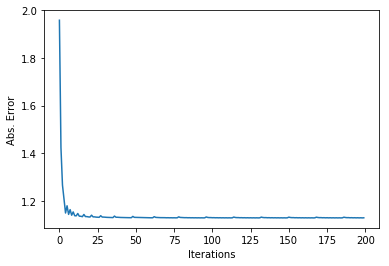

Time: 3571.477842092514
Train Accuracy: 0.6881829733163913
Dev Accuracy: 0.6551373346897253


In [4]:
# Final Experiments

# Full dataset
teams_s, dates_s, results_s = shuffle(unique_teams, unique_dates, unique_game_results, random_state=0)
train_n = 3935
full_n = 4919

# Runs w/o mini-batch for different learning rates (lr = 1E-6, 5E-7, 1E-7)
print('Starting full batch descent with lr = 1E-6')
model_lr_1e6 = QuadraticRegression(step_size = 1e-6, max_iter = 200)
x_lr_1e6, y_lr_1e6= model_lr_1e6.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
start = time.time()
model_lr_1e6.fit(x_lr_1e6, y_lr_1e6, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_1e6 = model_lr_1e6.general_predict(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
dev_accuracy_1e6 = model_lr_1e6.general_predict(teams_s[train_n+1:full_n], dates_s[train_n+1:full_n], 
                                                results_s[train_n+1:full_n])
errors_lr_1e6 = model_lr_1e6.error_list
print('Train Accuracy: {}'.format(train_accuracy_1e6))
print('Dev Accuracy: {}'.format(dev_accuracy_1e6))

Starting full batch descent with lr = 5E-7
Error 1: 9.793900452001324
Error 2: 10.301112679431576
Error 3: 15.371312258460764
Error 4: 13.968731129725837
Error 5: 12.717376418685365
Error 6: 14.10049336301694
Error 7: 14.972872914598694
Error 8: 14.168641772919337
Error 9: 14.006905332968804
Error 10: 14.042630922711004
Error 11: 14.448804156768544
Error 12: 14.017921230847126
Error 13: 14.24573484816756
Error 14: 13.964277934859181
Error 15: 14.31837601972788
Error 16: 13.932549897837267
Error 17: 14.270335246098318
Error 18: 13.899419675843932
Error 19: 14.268686873653683
Error 20: 13.873897925084632
Error 21: 14.246588177311285
Error 22: 13.852637024627175
Error 23: 14.23198556377116
Error 24: 13.836598217814345
Error 25: 14.21574384362259
Error 26: 13.824805313641214
Error 27: 14.202371154130555
Error 28: 13.816647945954028
Error 29: 14.190849322748532
Error 30: 13.811287042806349
Error 31: 14.181549637795573
Error 32: 13.808033655184401
Error 33: 14.174036296442297
Error 34: 13.80

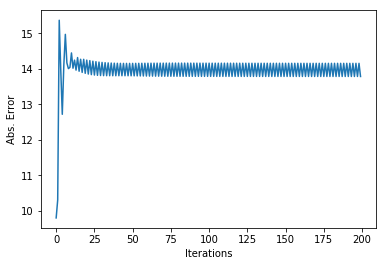

Time: 3499.2441890239716
Train Accuracy: 0.595425667090216
Dev Accuracy: 0.6063072227873856
Starting full batch descent with lr = 1E-7
Error 1: 1.958780090400264
Error 2: 1.424104260189626
Error 3: 1.2664308929558483
Error 4: 1.2073915762057867
Error 5: 1.1493643206030042
Error 6: 1.1797229623820547
Error 7: 1.1434761869609091
Error 8: 1.1635263574106662
Error 9: 1.1400970246365176
Error 10: 1.1538239666665002
Error 11: 1.137960707210328
Error 12: 1.1374073219846306
Error 13: 1.147313963684316
Error 14: 1.1359874296106784
Error 15: 1.135667401894145
Error 16: 1.1339176575698382
Error 17: 1.143226654341725
Error 18: 1.1343487746176824
Error 19: 1.1342454245799662
Error 20: 1.1329234468977871
Error 21: 1.1324775242160652
Error 22: 1.1401792873713525
Error 23: 1.133132984012156
Error 24: 1.1331043349464816
Error 25: 1.1320561895997865
Error 26: 1.1317464679825666
Error 27: 1.131290362664632
Error 28: 1.1379224806634853
Error 29: 1.1322907943687661
Error 30: 1.132194346847514
Error 31: 1.1

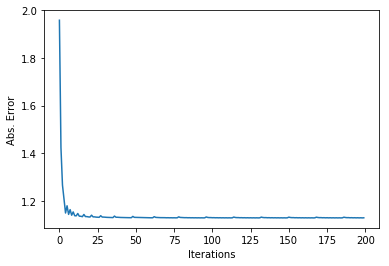

Time: 3569.7254588603973
Train Accuracy: 0.6881829733163913
Dev Accuracy: 0.6551373346897253


In [5]:
# Max_iters to be adjusted based on results above.
print('Starting full batch descent with lr = 5E-7')
model_lr_5e7 = QuadraticRegression(step_size = 5e-7, max_iter = 200)
x_lr_5e7, y_lr_5e7= model_lr_5e7.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
start = time.time()
model_lr_5e7.fit(x_lr_5e7, y_lr_5e7, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_5e7 = model_lr_5e7.general_predict(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
dev_accuracy_5e7 = model_lr_5e7.general_predict(teams_s[train_n+1:full_n], dates_s[train_n+1:full_n], 
                                                results_s[train_n+1:full_n])
errors_lr_5e7 = model_lr_5e7.error_list
print('Train Accuracy: {}'.format(train_accuracy_5e7))
print('Dev Accuracy: {}'.format(dev_accuracy_5e7))

print('Starting full batch descent with lr = 1E-7')
model_lr_1e7 = QuadraticRegression(step_size = 1e-7, max_iter = 200)
x_lr_1e7, y_lr_1e7= model_lr_1e7.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
start = time.time()
model_lr_1e7.fit(x_lr_1e7, y_lr_1e7, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_1e7 = model_lr_1e7.general_predict(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
dev_accuracy_1e7 = model_lr_1e7.general_predict(teams_s[train_n+1:full_n], dates_s[train_n+1:full_n], 
                                                results_s[train_n+1:full_n])
errors_lr_1e7 = model_lr_1e7.error_list
print('Train Accuracy: {}'.format(train_accuracy_1e7))
print('Dev Accuracy: {}'.format(dev_accuracy_1e7))

Starting full batch descent with lr = 1E-7
Error 1: 0.19587800904002642
Error 2: 0.18997700053895977
Error 3: 0.18432001692252709
Error 4: 0.17913663436609756
Error 5: 0.1743890533427177
Error 6: 0.17004039659506368
Error 7: 0.16605557971636167
Error 8: 0.16240180951931502
Error 9: 0.15904881806895763
Error 10: 0.1559689175986501
Error 11: 0.15313694009187243
Error 12: 0.15053010732971298
Error 13: 0.14812786315508328
Error 14: 0.14591168924029174
Error 15: 0.14386491811794258
Error 16: 0.14197255197064348
Error 17: 0.14022109208228592
Error 18: 0.13859838146051534
Error 19: 0.1370934615882928
Error 20: 0.1356964432898037
Error 21: 0.1343983911149104
Error 22: 0.13319122032538208
Error 23: 0.1320676054144018
Error 24: 0.13102089904643527
Error 25: 0.1300450603257504
Error 26: 0.12913459136105374
Error 27: 0.1282844811727823
Error 28: 0.1274901560769937
Error 29: 0.1267474357683454
Error 30: 0.12605249441004837
Error 31: 0.12540182611852876
Error 32: 0.12479221430367042
Error 33: 0.1242

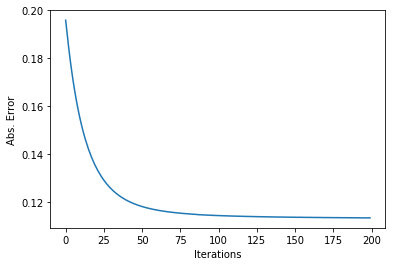

Time: 2164.48512506485
Train Accuracy: 0.6871664548919949
Dev Accuracy: 0.6500508646998983


In [7]:
print('Starting full batch descent with lr = 1E-7')
model_lr_1e7 = QuadraticRegression(step_size = 1e-7, max_iter = 200)
x_lr_1e7, y_lr_1e7= model_lr_1e7.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
start = time.time()
model_lr_1e7.fit(x_lr_1e7, y_lr_1e7, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_1e7 = model_lr_1e7.general_predict(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
dev_accuracy_1e7 = model_lr_1e7.general_predict(teams_s[train_n+1:full_n], dates_s[train_n+1:full_n], 
                                                results_s[train_n+1:full_n])
errors_lr_1e7 = model_lr_1e7.error_list
print('Train Accuracy: {}'.format(train_accuracy_1e7))
print('Dev Accuracy: {}'.format(dev_accuracy_1e7))

Starting full batch descent with lr = 5E-7
Error 1: 0.9535447662440103
Error 2: 0.8161280170757046
Error 3: 0.7279622752039958
Error 4: 0.6739590295291524
Error 5: 0.6392240768017594
Error 6: 0.6159707099453284
Error 7: 0.5998929918949617
Error 8: 0.5884688235622482
Error 9: 0.5801515303052527
Error 10: 0.5739590668064488
Error 11: 0.569250965798371
Error 12: 0.565600303402864
Error 13: 0.5586242393065766
Error 14: 0.5612562630805673
Error 15: 0.5559398582305021
Error 16: 0.5580431452963049
Error 17: 0.5538960337573376
Error 18: 0.5556158568516232
Error 19: 0.552307653013359
Error 20: 0.553744100624377
Error 21: 0.5510494035616473
Error 22: 0.5522722434335468
Error 23: 0.5500350298927064
Error 24: 0.5510936086045787
Error 25: 0.5492041434838575
Error 26: 0.55013394236112
Error 27: 0.5485137422416847
Error 28: 0.5475217048690375
Error 29: 0.5492091683824758
Error 30: 0.5477765080742378
Error 31: 0.5469124924908872
Error 32: 0.5484078155586273
Error 33: 0.547155073259079
Error 34: 0.5464

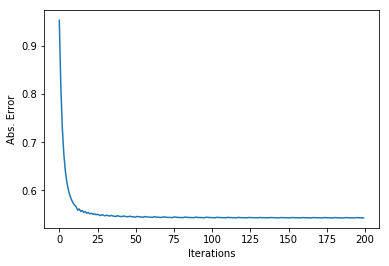

Time: 2291.6291749477386
Train Accuracy: 0.680559085133418
Dev Accuracy: 0.641912512716175


In [5]:
teams_s, dates_s, results_s = shuffle(unique_teams, unique_dates, unique_game_results, random_state=0)
train_n = 3935
full_n = 4919

print('Starting full batch descent with lr = 5E-7')
model_lr_5e7 = QuadraticRegression(step_size = 5e-7, max_iter = 200)
x_lr_5e7, y_lr_5e7= model_lr_5e7.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
start = time.time()
model_lr_5e7.fit(x_lr_5e7, y_lr_5e7, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_5e7 = model_lr_5e7.general_predict(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
dev_accuracy_5e7 = model_lr_5e7.general_predict(teams_s[train_n+1:full_n], dates_s[train_n+1:full_n], 
                                                results_s[train_n+1:full_n])
errors_lr_5e7 = model_lr_5e7.error_list
print('Train Accuracy: {}'.format(train_accuracy_5e7))
print('Dev Accuracy: {}'.format(dev_accuracy_5e7))

Starting full batch descent with lr = 2E-6
Error 1: 3.8979322156888476
Error 2: 2.5273502027724777
Error 3: 2.4959512538409965
Error 4: 2.3417850235060698
Error 5: 2.566116186364467
Error 6: 2.602906564578595
Error 7: 2.5410969120143068
Error 8: 2.404158277255347
Error 9: 2.4207751396368
Error 10: 2.352743326507679
Error 11: 2.3722861302150333
Error 12: 2.3366294177323454
Error 13: 2.3502300994602217
Error 14: 2.331071282731231
Error 15: 2.4523108875184105
Error 16: 2.57329516443091
Error 17: 2.5135915747980313
Error 18: 2.46021653383224
Error 19: 2.4413447504602415
Error 20: 2.4148068234354976
Error 21: 2.4040512843370423
Error 22: 2.390249989692957
Error 23: 2.3820844150162035
Error 24: 2.3747566405218334
Error 25: 2.3678201216208508
Error 26: 2.363947739894739
Error 27: 2.3578703475876397
Error 28: 2.355909139640606
Error 29: 2.350557527036809
Error 30: 2.3496801745081086
Error 31: 2.34497079643322
Error 32: 2.3447187314843414
Error 33: 2.3405760537530726
Error 34: 2.340688623592864

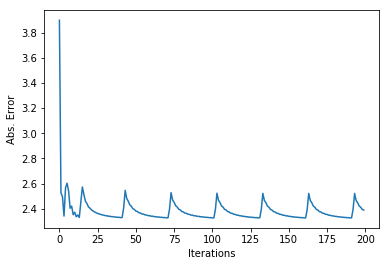

Time: 2070.8529040813446
Train Accuracy: 0.6810673443456162
Dev Accuracy: 0.6439471007121058


In [4]:
teams_s, dates_s, results_s = shuffle(unique_teams, unique_dates, unique_game_results, random_state=0)
train_n = 3935
full_n = 4919

print('Starting full batch descent with lr = 2E-6')
model_lr_2e6 = QuadraticRegression(step_size = 2e-6, max_iter = 200)
x_lr_2e6, y_lr_2e6= model_lr_2e6.process_data(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
start = time.time()
model_lr_2e6.fit(x_lr_2e6, y_lr_2e6, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_2e6 = model_lr_2e6.general_predict(teams_s[0:train_n], dates_s[0:train_n], results_s[0:train_n])
dev_accuracy_2e6 = model_lr_2e6.general_predict(teams_s[train_n+1:full_n], dates_s[train_n+1:full_n], 
                                                results_s[train_n+1:full_n])
errors_lr_2e6 = model_lr_2e6.error_list
np.savetxt('full_dataset_lr_2e6.txt', np.array(errors_lr_2e6), delimiter =',')
print('Train Accuracy: {}'.format(train_accuracy_2e6))
print('Dev Accuracy: {}'.format(dev_accuracy_2e6))

Starting full batch descent with lr = 1E-6
Error 1: 0.15233764875427086
Error 2: 0.149674241713044
Error 3: 0.1472288214254674
Error 4: 0.144920063555262
Error 5: 0.14274105149641783
Error 6: 0.14068476968558488
Error 7: 0.13874424224555548
Error 8: 0.13691263715969684
Error 9: 0.13518334155116368
Error 10: 0.13355001341760964
Error 11: 0.1320066146497951
Error 12: 0.1305474295073639
Error 13: 0.1291670720450438
Error 14: 0.12786048534094144
Error 15: 0.12662293480754755
Error 16: 0.1254499973774929
Error 17: 0.12433754794985327
Error 18: 0.12328174415228098
Error 19: 0.12227901020992706
Error 20: 0.12132602050372461
Error 21: 0.12041968323832361
Error 22: 0.11955712451498493
Error 23: 0.11873567300953337
Error 24: 0.11795284538370922
Error 25: 0.11720633250482895
Error 26: 0.11649398650941363
Error 27: 0.11581380871808054
Error 28: 0.11516393838893857
Error 29: 0.11454264228294582
Error 30: 0.11394830500562178
Error 31: 0.11337942008393427
Error 32: 0.11283458173418418
Error 33: 0.112

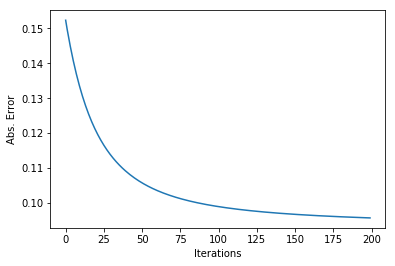

Time: 1381.0169880390167
Train Accuracy: 0.7232960325534079
Dev Accuracy: 0.6163265306122448


In [6]:
# 2014-2015 Season
teams_s1, dates_s1, results_s1 = shuffle(unique_teams[0:1229], unique_dates[0:1229], unique_game_results[0:1229], random_state=0)
train_s = 983
full_s = 1229

print('Starting full batch descent with lr = 1E-6')
model_s1_1e6 = QuadraticRegression(step_size = 1e-6, max_iter = 200)
x_s1_1e6, y_s1_1e6= model_s1_1e6.process_data(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
start = time.time()
model_s1_1e6.fit(x_s1_1e6, y_s1_1e6, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_s1_1e6 = model_s1_1e6.general_predict(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
dev_accuracy_s1_1e6 = model_s1_1e6.general_predict(teams_s1[train_s+1:full_s], dates_s1[train_s+1:full_s], 
                                                results_s1[train_s+1:full_s])
errors_s1_1e6 = model_s1_1e6.error_list
np.savetxt('2014_2015_lr_1e6.txt', np.array(errors_s1_1e6), delimiter =',')
print('Train Accuracy: {}'.format(train_accuracy_s1_1e6))
print('Dev Accuracy: {}'.format(dev_accuracy_s1_1e6))

Starting full batch descent with lr = 5E-7
Error 1: 0.07616882437713543
Error 2: 0.07550052733074475
Error 3: 0.07486913081083484
Error 4: 0.07425522281836609
Error 5: 0.07365840884799146
Error 6: 0.07307828324943065
Error 7: 0.07251443229714785
Error 8: 0.07196643694199592
Error 9: 0.07143387525877352
Error 10: 0.07091632460642275
Error 11: 0.07041336351944805
Error 12: 0.06992457335021252
Error 13: 0.06944953968220673
Error 14: 0.06898785353431573
Error 15: 0.06853911237564776
Error 16: 0.0681029209697377
Error 17: 0.0676788920659749
Error 18: 0.06726664695500943
Error 19: 0.06686581590371307
Error 20: 0.0664760384840573
Error 21: 0.06609696380906069
Error 22: 0.06572825068776908
Error 23: 0.0653695677100926
Error 24: 0.06502059327124085
Error 25: 0.06468101554448151
Error 26: 0.06435053241000464
Error 27: 0.0640288513468046
Error 28: 0.06371568929369378
Error 29: 0.06341077248483892
Error 30: 0.06311383626455189
Error 31: 0.06282462488547617
Error 32: 0.06254289129377828
Error 33: 0

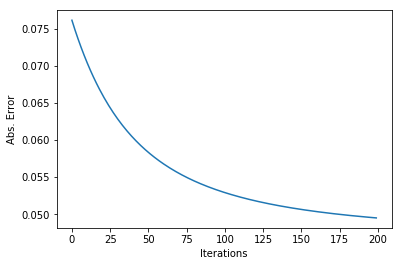

Time: 1291.1925339698792
Train Accuracy: 0.7151576805696847
Dev Accuracy: 0.636734693877551


In [7]:
print('Starting full batch descent with lr = 5E-7')
model_s1_5e7 = QuadraticRegression(step_size = 5e-7, max_iter = 200)
x_s1_5e7, y_s1_5e7= model_s1_5e7.process_data(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
start = time.time()
model_s1_5e7.fit(x_s1_5e7, y_s1_5e7, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_s1_5e7 = model_s1_5e7.general_predict(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
dev_accuracy_s1_5e7 = model_s1_5e7.general_predict(teams_s1[train_s+1:full_s], dates_s1[train_s+1:full_s], 
                                                results_s1[train_s+1:full_s])
errors_s1_5e7 = model_s1_5e7.error_list
np.savetxt('2014_2015_lr_5e7.txt', np.array(errors_s1_5e7), delimiter =',')
print('Train Accuracy: {}'.format(train_accuracy_s1_5e7))
print('Dev Accuracy: {}'.format(dev_accuracy_s1_5e7))

Starting full batch descent with lr = 1E-7
Error 1: 0.015233764875427084
Error 2: 0.015206958481368212
Error 3: 0.015181065800716183
Error 4: 0.015155315056162749
Error 5: 0.015129705684978146
Error 6: 0.015104237118390911
Error 7: 0.01507890878182961
Error 8: 0.015053720095160544
Error 9: 0.015028670472921496
Error 10: 0.015003759324551476
Error 11: 0.014978986054616438
Error 12: 0.01495435006303096
Error 13: 0.014929850745275995
Error 14: 0.014905487492612526
Error 15: 0.014881259692291267
Error 16: 0.014857166727758355
Error 17: 0.014833207978857097
Error 18: 0.014809382822025733
Error 19: 0.014785690630491233
Error 20: 0.014762130774459243
Error 21: 0.01473870262130005
Error 22: 0.014715405535730707
Error 23: 0.01469223887999335
Error 24: 0.014669202014029624
Error 25: 0.014646294295651357
Error 26: 0.014623515080707488
Error 27: 0.014600863723247213
Error 28: 0.014578339575679557
Error 29: 0.014555941988929146
Error 30: 0.014533670312588494
Error 31: 0.014511523895066623
Error 32:

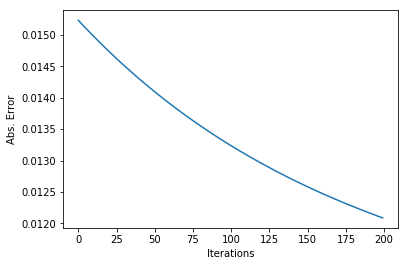

Time: 1316.0007050037384
Train Accuracy: 0.6927772126144456
Dev Accuracy: 0.6163265306122448


In [9]:
print('Starting full batch descent with lr = 1E-7')
model_s1_1e7 = QuadraticRegression(step_size = 1e-7, max_iter = 200)
x_s1_1e7, y_s1_1e7= model_s1_1e7.process_data(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
start = time.time()
model_s1_1e7.fit(x_s1_1e7, y_s1_1e7, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_s1_1e7 = model_s1_1e7.general_predict(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
dev_accuracy_s1_1e7 = model_s1_1e7.general_predict(teams_s1[train_s+1:full_s], dates_s1[train_s+1:full_s], 
                                                results_s1[train_s+1:full_s])
errors_s1_1e7 = model_s1_1e7.error_list
np.savetxt('2014_2015_lr_5e7.txt', np.array(errors_s1_1e7), delimiter =',')
print('Train Accuracy: {}'.format(train_accuracy_s1_1e7))
print('Dev Accuracy: {}'.format(dev_accuracy_s1_1e7))

Starting full batch descent with lr = 2E-6
Error 1: 0.3046752975085417
Error 2: 0.2941060269628839
Error 3: 0.28496753754533305
Error 4: 0.27685601741226606
Error 5: 0.2696526013955165
Error 6: 0.263246063136607
Error 7: 0.2575359178825744
Error 8: 0.2524333327777796
Error 9: 0.247860813264812
Error 10: 0.24375128500285553
Error 11: 0.2400469383034622
Error 12: 0.23669803790534236
Error 13: 0.2336618010086416
Error 14: 0.23090138872911203
Error 15: 0.22838502435316033
Error 16: 0.22608523535100544
Error 17: 0.22397820844501434
Error 18: 0.22204324419230387
Error 19: 0.2202622972322835
Error 20: 0.21861958927004044
Error 21: 0.217101283297409
Error 22: 0.2156952091136221
Error 23: 0.21439063170565084
Error 24: 0.2131780553993953
Error 25: 0.2120490578683189
Error 26: 0.2109961490865757
Error 27: 0.21001265115349005
Error 28: 0.20909259561500879
Error 29: 0.20823063548597695
Error 30: 0.20742196965402207
Error 31: 0.206662277738593
Error 32: 0.205947663801985
Error 33: 0.2052746075753852

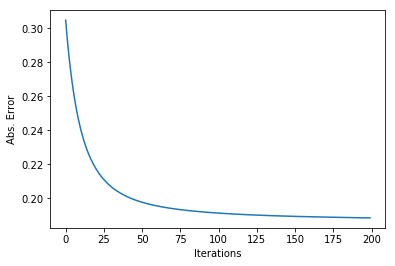

Time: 1692.7800650596619
Train Accuracy: 0.7202441505595117
Dev Accuracy: 0.6408163265306123


In [11]:
print('Starting full batch descent with lr = 2E-6')
model_s1_2e6 = QuadraticRegression(step_size = 2e-6, max_iter = 200)
x_s1_2e6, y_s1_2e6= model_s1_2e6.process_data(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
start = time.time()
model_s1_2e6.fit(x_s1_2e6, y_s1_2e6, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_s1_2e6 = model_s1_2e6.general_predict(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
dev_accuracy_s1_2e6 = model_s1_2e6.general_predict(teams_s1[train_s+1:full_s], dates_s1[train_s+1:full_s], 
                                                results_s1[train_s+1:full_s])
errors_s1_2e6 = model_s1_2e6.error_list
np.savetxt('2014_2015_lr_2e6.txt', np.array(errors_s1_2e6), delimiter =',')
print('Train Accuracy: {}'.format(train_accuracy_s1_2e6))
print('Dev Accuracy: {}'.format(dev_accuracy_s1_2e6))

Starting full batch descent with lr = 4E-6
Error 1: 0.6093505950170834
Error 2: 0.5678417236841942
Error 3: 0.5363229386089604
Error 4: 0.5117269824083748
Error 5: 0.49231876390108664
Error 6: 0.47679804124949465
Error 7: 0.46421739057905437
Error 8: 0.45388888698345314
Error 9: 0.44530938167257433
Error 10: 0.4381064896100798
Error 11: 0.4320008723929178
Error 12: 0.4267801100699285
Error 13: 0.42228053072696053
Error 14: 0.4183744543354615
Error 15: 0.4149611298617743
Error 16: 0.41196021264800864
Error 17: 0.4093070084023683
Error 18: 0.40694896087332233
Error 19: 0.40484302615316314
Error 20: 0.4029536869945813
Error 21: 0.4012514347451653
Error 22: 0.39971159692790187
Error 23: 0.39831342314507545
Error 24: 0.3970393660701387
Error 25: 0.3958745112294732
Error 26: 0.3948061213193613
Error 27: 0.39382326945981283
Error 28: 0.39291654207356036
Error 29: 0.39207779668981
Error 30: 0.39129996338700546
Error 31: 0.3905768811404938
Error 32: 0.38990316226428223
Error 33: 0.3892740795977

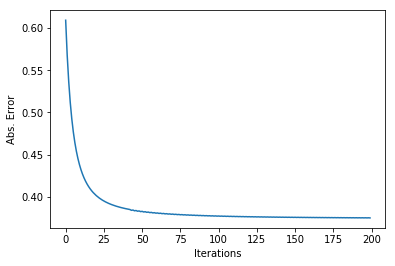

Time: 1676.7337589263916
Train Accuracy: 0.7222787385554426
Dev Accuracy: 0.6408163265306123


In [12]:
print('Starting full batch descent with lr = 4E-6')
model_s1_4e6 = QuadraticRegression(step_size = 4e-6, max_iter = 200)
x_s1_4e6, y_s1_4e6= model_s1_4e6.process_data(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
start = time.time()
model_s1_4e6.fit(x_s1_4e6, y_s1_4e6, mini=False)
end = time.time()
print('Time: {}'.format(end-start))
train_accuracy_s1_4e6 = model_s1_4e6.general_predict(teams_s1[0:train_s], dates_s1[0:train_s], results_s1[0:train_s])
dev_accuracy_s1_4e6 = model_s1_4e6.general_predict(teams_s1[train_s+1:full_s], dates_s1[train_s+1:full_s], 
                                                results_s1[train_s+1:full_s])
errors_s1_4e6 = model_s1_4e6.error_list
np.savetxt('2014_2015_lr_4e6.txt', np.array(errors_s1_4e6), delimiter =',')
print('Train Accuracy: {}'.format(train_accuracy_s1_4e6))
print('Dev Accuracy: {}'.format(dev_accuracy_s1_4e6))